In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.stats import uniform

from jne_functions import *
from ipywidgets import interactive, FloatSlider

In [2]:
df=pd.read_csv('bank_marketing_modified.csv',index_col=[0])
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,cons.conf.idx,euribor3m,nr.employed,deposit,age_group,season,pdays_bin,year,employment,month_num
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,-36.4,4.857,5191.0,0,Adult,spring,0,2008,employed,5
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,-36.4,4.857,5191.0,0,Middle-aged,spring,0,2008,employed,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-50.8,1.028,4963.6,1,Senior,fall,0,2010,retired,11
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,employed,11
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-50.8,1.028,4963.6,0,Middle-aged,fall,0,2010,retired,11
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-50.8,1.028,4963.6,1,Middle-aged,fall,0,2010,employed,11


# Modeling with Naive Bayes

In [3]:
X=df.loc[:,['campaign','previous','emp.var.rate','year',
            'cons.price.idx','cons.conf.idx','euribor3m','nr.employed',
            'job','marital','education','poutcome',
            'default','housing','loan','month','day_of_week','pdays_bin','age_group']]
y=df['deposit']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [5]:
    numeric_features=['year','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed',]
    numeric_transformer= Pipeline(steps=[ ('ss',StandardScaler())])

    categorical_features=['poutcome','job','marital','education','default','housing','loan','month','day_of_week','age_group']
    categorical_transformer=OneHotEncoder(handle_unknown='error',drop='first')

    preprocessor= ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_features),
            ('cat', categorical_transformer,categorical_features)
        ])

    pipe=Pipeline(steps=[('prep',preprocessor),
                        ('Berni',BernoulliNB())])
    pipe.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['year', 'campaign',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['poutcome', 'job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'month',
                  

In [6]:
def make_confusion_matrix(model, threshold=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    deposit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    group_counts=['{0:0.0f}'.format(value) for value in deposit_confusion.flatten()]
    group_perc=['{0:.2%}'.format(value) for value in deposit_confusion.flatten()/np.sum(deposit_confusion)]
    labels=[f'{v1}\n{v2}' for v1,v2 in zip(group_counts,group_perc)]
    labels=np.asarray(labels).reshape(2,2)
    sns.heatmap(deposit_confusion, cmap=plt.cm.Blues, annot=labels, square=True, fmt='',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes']);
    plt.xlabel('Prediction').set_color('black')
    plt.ylabel('Actual').set_color('black')
    plt.title ('Naive Bayes Confusion matrix')
    plt.tick_params(colors='black')

In [7]:
interactive(lambda threshold: make_confusion_matrix(pipe, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

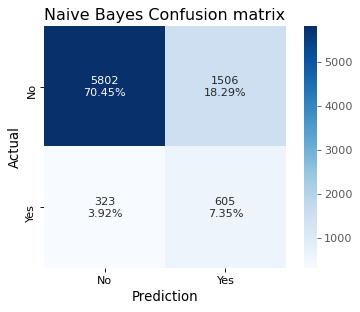

In [8]:
make_confusion_matrix(pipe,0.50)
plt.savefig('NB_confusion_matrix.svg',format='svg');

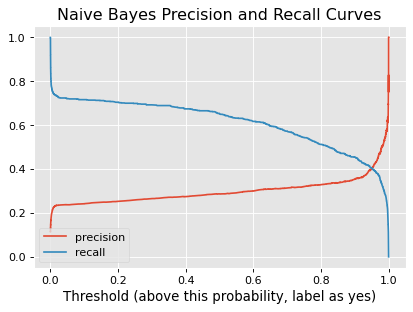

In [9]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)').set_color('black')
plt.tick_params(colors='black')
plt.title('Naive Bayes Precision and Recall Curves');
plt.savefig('NB_prcurve.svg',format='svg')

In [10]:
y_predict = pipe.predict(X_test)
f1_score(y_test, y_predict)
#0.423 with age
#0.421 without age

0.3981572885817703

In [11]:
#y_predict = (pipe.predict_proba(X_test)[:, 1] > 0.3)
#f1_score(y_test, y_predict)
#0.398 with age

In [12]:
#a higher beta more heavily weighs recall
y_predict = pipe.predict(X_test)
fbeta_score(y_test, y_predict,average='macro',beta=3)
#weighted, beta=5, 0.8194768553587276 with age
#macro, beta 3 0.7016280319381358 wtih age
# macro b=3 without age 0.7006074914846923

0.6926079079237982

In [13]:
y_predict = pipe.predict(X_test)
f1_score(y_test, y_predict, average='macro')
#0.658 with age
#0.657 without age

0.6310000319183697

In [14]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      7308
           1       0.29      0.65      0.40       928

    accuracy                           0.78      8236
   macro avg       0.62      0.72      0.63      8236
weighted avg       0.87      0.78      0.81      8236



In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

ROC AUC score =  0.7634850152407376


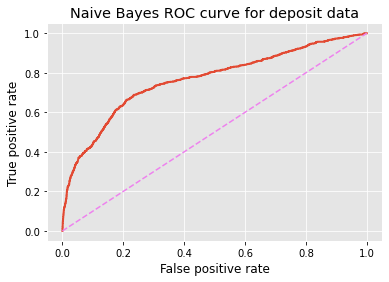

In [16]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.tick_params(colors='black')
plt.xlabel('False positive rate').set_color('black')
plt.ylabel('True positive rate').set_color('black')
plt.title('Naive Bayes ROC curve for deposit data');
plt.savefig('NB_ROC.svg',format='svg')
print("ROC AUC score = ", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))

# RANDOM OVERSAMPLING

In [17]:
X=df.loc[:,['campaign','previous','emp.var.rate','year',
            'cons.price.idx','cons.conf.idx','euribor3m',
            'nr.employed','job','marital','education','poutcome',
            'default','housing','loan','month','day_of_week','pdays_bin','age_group']]
y=df['deposit']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [19]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
ros_X_train, ros_y_train = ros.fit_sample(X_train,y_train)

In [20]:
    numeric_features=['year','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx']
    numeric_transformer= Pipeline(steps=[ ('ss',StandardScaler())])

    categorical_features=['poutcome','job','marital','education','default','housing','loan','month','day_of_week','age_group']
    categorical_transformer=OneHotEncoder(handle_unknown='error',drop='first')

    preprocessor= ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_features),
            ('cat', categorical_transformer,categorical_features)
        ])

    pipe=Pipeline(steps=[('prep',preprocessor),
                        ('Berni',BernoulliNB())])
    pipe.fit(ros_X_train,ros_y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['year', 'campaign',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['poutcome', 'job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'month',
                                                   'day_of_week',
                               

In [21]:
def make_confusion_matrix(model, threshold=0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    deposit_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    group_counts=['{0:0.0f}'.format(value) for value in deposit_confusion.flatten()]
    group_perc=['{0:.2%}'.format(value) for value in deposit_confusion.flatten()/np.sum(deposit_confusion)]
    labels=[f'{v1}\n{v2}' for v1,v2 in zip(group_counts,group_perc)]
    labels=np.asarray(labels).reshape(2,2)
    sns.heatmap(deposit_confusion, cmap=plt.cm.Blues, annot=labels, square=True, fmt='',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes']);
    plt.xlabel('Prediction').set_color('black')
    plt.ylabel('Actual').set_color('black')
    plt.title ('Naive Bayes Confusion matrix')
    plt.tick_params(colors='black')

In [22]:
interactive(lambda threshold: make_confusion_matrix(pipe, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

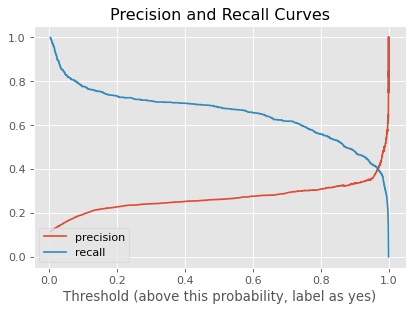

In [23]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as yes)');
plt.title('Precision and Recall Curves');

In [24]:
y_predict = pipe.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      7308
           1       0.26      0.68      0.38       928

    accuracy                           0.75      8236
   macro avg       0.61      0.72      0.61      8236
weighted avg       0.87      0.75      0.79      8236



ROC AUC score =  0.7630267314515977


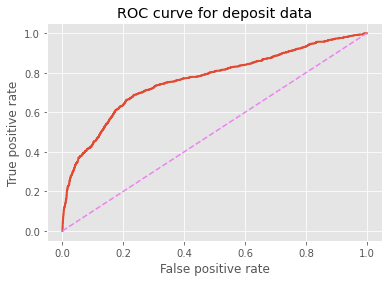

In [25]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for deposit data');
print("ROC AUC score = ", roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))